# FaceNet

## 환경 구성

소스코드를 실행하는데 필요한 런타임 환경을 구성합니다.

 * 의존성 설치: 소스코드를 실행하는데 필요한 의존성 모듈을 설치합니다.
 * (Google Colab) 경로 정의: 이 문서는 Google Colab에서 작성되고 실행되어, 별도의 연결 설정 코드가 포함되어있습니다.

### 의존성 설치

In [1]:
# Install dependencies
!pip install tensorflow mtcnn Pillow numpy opencv-python matplotlib scikit-learn keras-facenet pickle5 joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10385 sha256=5eb6168e1d0f90bce2bb5f1032c02425f3ba010ab29e592b6f5ce1a811c69ae9
  Stored in directory: /root/.cache/pip/wheels/73/5d/41/90b5d28ca667cfc4748ae859fa4f0b85b936d73207a073ded5
  Created wheel for pickle5: filename=pickle5-0.0.11-cp39-cp39-linux_x86_64.whl size=255905 sha256=74661d897907ea68b858e178ce2e8ba1fde3b7a7524966566383610e8041b0a9
  Stored in directory: /root/.cache/pip/wheels/f2/7a/49/9bef8878949914ecb90c08fc5bf30a05e17f475fe7e08b63a8
Successfully built keras-facenet pickle5


### Google Colab 마운트 처리

`PATH`와 `DATASET`은 이후 계속 사용하는 오프셋 상수로, Googla Colab 환경에서 셀을 실행하였기 때문에 추가되었습니다.  
이어지는 아래 코드에서 두 변수를 계속해서 사용하므로 다른 환경에서 본 셀을 제거하거나 건너뛰지 않고 두 상수를 오버라이드하는 것을 권장합니다.  

```python
PATH = '/content/gdrive/MyDrive/Workspaces/gua'
DATASET = 'demo'
```

In [2]:
# Link google drive
from google.colab import drive
drive.mount('/content/gdrive')
PATH = '/content/gdrive/MyDrive/Workspaces/gua'
DATASET = 'demo'

Mounted at /content/gdrive


## 공통 요소 정의

아래 정의는 이어지는 코드에서 두 번 이상 사용되거나 코드를 더 확장할 때 두 번 이상 사용될 가능성이 높은 정의입니다. 

### 얼굴 데이터 래퍼 클래스

`Face` 클래스는 이후 얼굴 인식 AI 모델이 사용하거나 도출하는 값을 한 데 모으는데 사용하기 위해 정의되었습니다.  

 * `x`, `y`, `w`, `h` 속성은 MTCNN이 인식한 얼굴 범위입니다.
 * `face` 속성은 MTCNN이 인식한 얼굴의 수치화(벡터화)된 데이터입니다.
 * `embedding` 속성은 `face` 속성의 임베딩 결과입니다.
 * `label` 속성은 FaceNet이 도출한 얼굴 인식 결과값입니다.

In [3]:
from numpy import ndarray

class Face:
  def __init__(self, x: int, y: int, w: int, h: int, face: ndarray, embedding: ndarray=None, label: str=None):
    self.x: int = x
    self.y: int = y
    self.w: int = w
    self.h: int = h
    self.face: ndarray = face
    self.embedding: ndarray = embedding
    self.label: str = label

### 얼굴 추출

```python
def extract_face(rgb_vector: ndarray, size: tuple=(160, 160)) -> list[Face]
```

`extract_face` 함수는 얼굴을 추출하기 위해 정의되었습니다. MTCNN을 이용하여 사진에서 한 개 이상의 얼굴들을 인식하고 추출하여 수치화된 데이터 목록을 반환합니다.  

**입력**  
이 함수는 `PIL.Image`에 의해 수치화된 이미지 RGB 데이터를 입력받습니다. (`rgb_vector`)  
인식된 얼굴은 특정한 크기의 이미지로 고정(변환)하여 이후 AI 모델이 일관되게 인식 처리를 할 수 있게 합니다. 이 크기 설정값은 별도로 지정할 수 있으며, 기본값은 `(160, 160)`입니다.  

**출력**  
이 함수가 반환하는 `Face` 데이터는 아직 임베딩 처리나 얼굴 인식(라벨링)을 수행하지 않았으므로 `x`, `y`, `w`, `h`, `face` 속성만 유효합니다.  

In [4]:
from PIL import Image
from numpy import asarray, ndarray
from mtcnn.mtcnn import MTCNN

def extract_face(rgb_vector: ndarray, size: tuple=(160, 160)) -> list[Face]:
  pixels = asarray(rgb_vector)
  model = MTCNN()
  model_query_result = model.detect_faces(pixels)

  faces: list[Face] = []
  for result in model_query_result:
    # process each result box
    x1, y1, w, h = result['box']
    x1, y1 = abs(x1), abs(y1)
    face = pixels[y1:y1+h, x1:x1+w]
    # reform size
    resized = asarray(
        Image.fromarray(face).resize(size)
    )
    faces.append(Face(x1, y1, w, h, resized))
  return faces

### 데이터셋 파일 일괄 `extract_face`

```python
def load_faces(path: str) -> dict
```

이미지 파일만 위치한 폴더에서 이미지를 일괄적으로 로드한 후 얼굴 추출 처리를 수행하기 위해 정의되었습니다.  

**입력**  
`path`는 이미지 파일만 위치한 폴더의 경로입니다. 별도의 예외처리가 없으므로 만약 `path` 경로의 폴더 내에 이미지 외의 다른 파일이 있다면 파일 로드 과정에서 오류가 발생됩니다.  

**출력**  
`파일 이름`: `얼굴 벡터 배열` 을 키-값 쌍으로 갖는 딕셔너리를 반환합니다.  

In [5]:
from os import listdir
from os.path import join
from PIL import Image
from numpy import asarray, ndarray

def load_faces(path: str) -> dict:
  '''
  :returns: { (filename: str): (face vectors: list[Face]) }
  '''
  facelist = dict()
  for file in listdir(path):
    now = join(path, file)
    image_ndarray: ndarray = asarray(
      Image.open(now).convert('RGB')
    )
    faces: list[Face] = extract_face(image_ndarray)
    facelist[file] = faces
  return facelist

### 얼굴 임베딩

```python
def get_embedding(model, face: Face)
```

각 `Face` 값에 대해 임베딩 처리 결과를 반환합니다.  

**주의**  
이 함수는 임베딩을 반환하지만 입력된 `Face` 객체의 `embedding` 속성에 처리 결과를 추가하지는 않습니다.  

In [6]:
from numpy import ndarray
from numpy.lib.shape_base import expand_dims

def get_embedding(model, face: Face):
  face_pixels_f32: ndarray = face.face.astype('float32')
  mean, std = face_pixels_f32.mean(), face_pixels_f32.std()

  face_pixels_norm: ndarray = (face_pixels_f32 - mean) / std
  samples = expand_dims(face_pixels_norm, axis=0)
  
  # predict[0] => follow by sklearn spec
  yhat = model.predict(samples)[0]
  return yhat

## 모델 구축 처리

### 데이터셋 로드

훈련 데이터와 검증 데이터를 갖고 있는 데이터셋을 불러오는데 사용하기 위해 정의되었습니다.  

**호환 데이터셋 구조**
```
root
 - train
  - each1
    - file1
    - file2
    - ...
  - each2
  - ...
 - val
  - each1
  -...
```

**파트별 (train, test, validation) 로드 정의**  

```python
def load_dataset_each_partition(path: str) -> list[Face]
```

위의 호환 데이터셋 구조에서 첫 단계의 하위 디렉토리를 일괄적으로 로드하기 위해 정의되었습니다. 위 구조에서 첫 단계의 하위 디렉토리는 데이터의 용도에 따라 `train`, `validation`, `test` 등으로 구분됩니다.  

**데이터셋 전체 로드 정의**  

```python
def load_dataset(model, path: str, postfix: tuple=('train', 'val')) -> tuple[ndarray]
```

위의 호환 데이터셋 전체를 불러오기 위해 정의되었습니다. `load_dataset_each_partition`을 호출하는 래퍼 함수로, `postfix` 매개변수로 훈련 데이터와 검증 데이터의 디렉토리 이름을 특정할 수 있습니다. (기본값은 훈련 데이터 `train`, 검증 데이터 `val` 입니다.)  

**출력**  

```python
(train_x, train_y, test_x, test_y)
```

데이터셋 전체를 불러온 뒤, 로드된 데이터의 임베딩과 라벨을 생성합니다. 생성된 두 데이터는 각각 `x`, `y`로 구분되어 훈련 데이터와 검증 데이터로 나누어 위와 같이 크기 4의 튜플로 반환합니다.  


In [7]:
from os import listdir
from os.path import join

def load_dataset_each_partition(path: str) -> list[Face]:
  # 'root/train', 'root/val'
  faces_merged: list[Face] = list()
  for subdir in listdir(path): # 'root/train/each', 'root/val/each'
    file: str = join(path, subdir)
    faces: dict = load_faces(file) # 'root/train/each/file', 'root/val/each/file'

    # training phase: ignoreing multiple face detection
    for each in faces:
      now: list = faces[each]
      if len(now) == 0: continue
      face: Face = now[0]
      face.label = subdir
      faces_merged.extend([face])
  return faces_merged
    

In [8]:
from numpy import ndarray

def load_dataset(model, path: str, postfix: tuple=('train', 'val')) -> tuple[ndarray]:
  # 'root'

  # load dataset partition
  train: list[Face] = load_dataset_each_partition('{path}/{subdir}'.format(
      path = path, subdir = postfix[0]
  ))
  test: list[Face] = load_dataset_each_partition('{path}/{subdir}'.format(
      path = path, subdir = postfix[1]
  ))

  # get embedding
  train_x, train_y, test_x, test_y = list(), list(), list(), list()
  for face in train:
    embedding: ndarray = get_embedding(model, face)
    face.embedding = embedding
    train_x.append(embedding)
    train_y.append(face.label)
  for face in test:
    embedding: ndarray = get_embedding(model, face)
    face.embedding = embedding
    test_x.append(embedding)
    test_y.append(face.label)

  return train_x, train_y, test_x, test_y

### 모델 구축 러너

```python
def build_model(dataset_path: str, labeler_path: str, classifier_path: str)
```

데이터셋을 로드하고 임베딩과 라벨 셋을 생성하여 그 결과를 파일로 저장합니다.  

**입력**  
 * `dataset_path`: 로드할 데이터셋의 경로입니다.  
 * `labeler_path`: 라벨 데이터를 저장할 경로입니다.  
 * `classifier_path`: 임베딩을 학습한 결과를 저장할 경로입니다.

In [9]:
from keras_facenet import FaceNet
from sklearn import preprocessing, svm
from sklearn.metrics import accuracy_score
from pickle5 import dump as pdump
from joblib import dump as jdump

def build_model(dataset_path: str, labeler_path: str, classifier_path: str):
  model = FaceNet()
  train_x, train_y, test_x, test_y = load_dataset(model.model, f'{PATH}/{dataset_path}')

  in_encoder = preprocessing.Normalizer(norm='l2')
  train_x_transformed = in_encoder.transform(train_x)
  test_x_transformed = in_encoder.transform(test_x)

  out_encoder = preprocessing.LabelEncoder()
  out_encoder.fit(train_y)
  train_y_transformed = out_encoder.transform(train_y)
  test_y_transformed = out_encoder.transform(test_y)

  # output labeler
  file_labeler = open(f'{PATH}/{labeler_path}', 'wb')
  pdump(out_encoder, file_labeler)
  file_labeler.close()

  # fitting model
  classifier = svm.SVC(kernel='linear', probability=True)
  classifier.fit(train_x_transformed, train_y_transformed)

  # predict
  yhat_train = classifier.predict(train_x_transformed)
  score_train = accuracy_score(train_y_transformed, yhat_train)
  yhat_test = classifier.predict(test_x_transformed)
  score_test = accuracy_score(test_y_transformed, yhat_test)

  # output classifier
  jdump(classifier, f'{PATH}/{classifier_path}')

  print(f'Accuracy: train={score_train*100}, test={score_test*100}')

#### 모델 구축 시작
`build_model` 함수를 호출하여 모델을 구축합니다.  

In [ ]:
build_model(DATASET, f'assets/{DATASET}_labeler.pk1', f'assets/{DATASET}_classifier.pk1')

## 모델 사용, 작동 테스트

`build_model`을 통해 생성한 AI 모델을 로드하여 정상적으로 작동하는지 테스트합니다.  

### 예측

```python
def predict(filepath: str) -> None
```

`filepath` 경로에 위치한 이미지 파일 속 인물을 학습된 데이터 내에서 검색합니다. 그 결과, 가장 유사한 것으로 판단되는 인물의 정보를 가져옵니다.  

**출력**  
결과는 matplotlib의 imshow와 표준스트림을 통해 출력되어 별도의 반환값이 없습니다.  

In [11]:
from keras_facenet import FaceNet
from sklearn import preprocessing
from numpy import asarray, ndarray
from PIL import Image, ImageDraw, ImageFont
from joblib import load as jload
from matplotlib.pyplot import imshow

labeler = jload(f'{PATH}/assets/{DATASET}_labeler.pk1')
classifier = jload(f'{PATH}/assets/{DATASET}_classifier.pk1')

def predict(filepath: str):

  image: Image = Image.open(filepath).convert('RGB')
  image_ndarray: ndarray = asarray(image)
  model = FaceNet()
  faces: list[Face] = extract_face(image_ndarray)

  in_encoder = preprocessing.Normalizer(norm='l2')

  for face in faces:
    embedding: ndarray = expand_dims(get_embedding(model.model, face), axis=0)

    # use scikit-learn
    face.embedding = in_encoder.transform(embedding)

    # classify
    yhat: ndarray = classifier.predict(embedding)
    prob: ndarray = classifier.predict_proba(embedding)
    label: ndarray = labeler.inverse_transform(yhat)

    # draw result
    draw: ImageDraw = ImageDraw.Draw(image)
    draw.rectangle(((face.x, face.y), (face.x + face.w, face.y + face.h)), outline=(255, 0, 0), width=3)
    draw.rectangle(((face.x, face.y), (face.x + face.w // 2, face.y - face.h // 10)), fill=(255, 0, 0))
    font: ImageFont = ImageFont.truetype(f'{PATH}/assets/SUIT-Variable.ttf')
    draw.text((face.x, face.y - face.h // 10), label[0], fill=(255, 255, 255), font=font)
    imshow(asarray(image.convert('RGB')))
 
    # print result
    buf = []
    buf.append(f'label: {label[0]}')
    buf.append(f'prob: {prob[0][yhat][0]*100}')
    print('\n'.join(buf))


1/1 [==============================] - 2s 2s/step
label: dbdfb375-c57a-4086-a0bb-906ffa393973
prob: 45.169600215291275


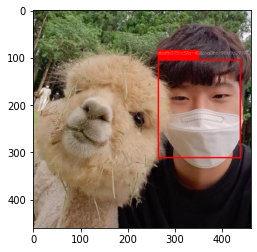

In [12]:
predict(f'{PATH}/assets/target.jpg')

### 결과 해설

학습에 사용한 데이터셋은 Gua 데모에 도입하기 위해 준비한 데이터셋입니다.  
Gua 데모에서 일관되게 인물 데이터를 처리할 수 있도록 모든 인물에 UUID를 부여하고, 모델에게 UUID를 학습하도록 하였습니다.  

데모 데이터셋에서 `dbdfb375-c57a-4086-a0bb-906ffa393973` UUID는 작성자, 박종현을 의미합니다. (자세한 내용은 데이터셋에 포함된 `README.md` 파일을 참조하세요.)  

결과적으로 AI 모델은 사진 속 인물을 제대로 판단했습니다. 다만 정확도(`prob`)가 다소 낮은 값을 보이는데, 얼굴 절반 이상이 마스크로 가려져 있음을 고려하면 45%에 이르는 정확도는 상당히 높은 것으로 판단할 수 있습니다.